## Overview
This notebook demonstrates different quantum neural network (QNN) implementations provided in `qiskit-machine-learning`, and how they can be integrated into basic quantum machine learning (QML) workflows.

The tutorial is structured as follows:

1. [Introduction](#1.-Introduction)
2. [How to Instantiate QNNs](#2.-How-to-Instantiate-QNNs)
3. [How to Run a Forward Pass](#3.-How-to-Run-a-Forward-Pass)
4. [How to Run a Backward Pass](#4.-How-to-Run-a-Backward-Pass)
5. [Advanced Functionality](#5.-Advanced-Functionality)
6. [Conclusion](#6.-Conclusion)

## 1. Introduction

### 1.1. Quantum vs. Classical Neural Networks

Classical neural networks are algorithmic models inspired by the human brain that can be trained to recognize patterns in data and learn to solve complex problems. They are based on a series of interconnected nodes, or *neurons*, organized in a layered structure, with parameters that can be learned by applying machine or deep learning training strategies.

The motivation behind quantum machine learning (QML) is to integrate notions from quantum computing and classical machine learning to open the way for new and improved learning schemes. QNNs apply this generic principle by combining classical neural networks and parametrized quantum circuits. Because they lie at an intersection between two fields, QNNs can be viewed from two perspectives:

- From a **machine learning perspective**, QNNs are, once again, algorithmic models that can be trained to find hidden patterns in data in a similar manner to their classical counterparts. These models can **load** classical data (**inputs**) into a quantum state, and later **process** it with quantum gates parametrized by **trainable weights**. Figure 1 shows a generic QNN example including the data loading and processing steps. The output from measuring this state can then be plugged into a loss function to train the weights through backpropagation.

- From a **quantum computing perspective**, QNNs are quantum algorithms based on parametrized quantum circuits that can be trained in a variational manner using classical optimizers. These circuits contain a **feature map** (with input parameters) and an **ansatz** (with trainable weights), as seen in Figure 1.

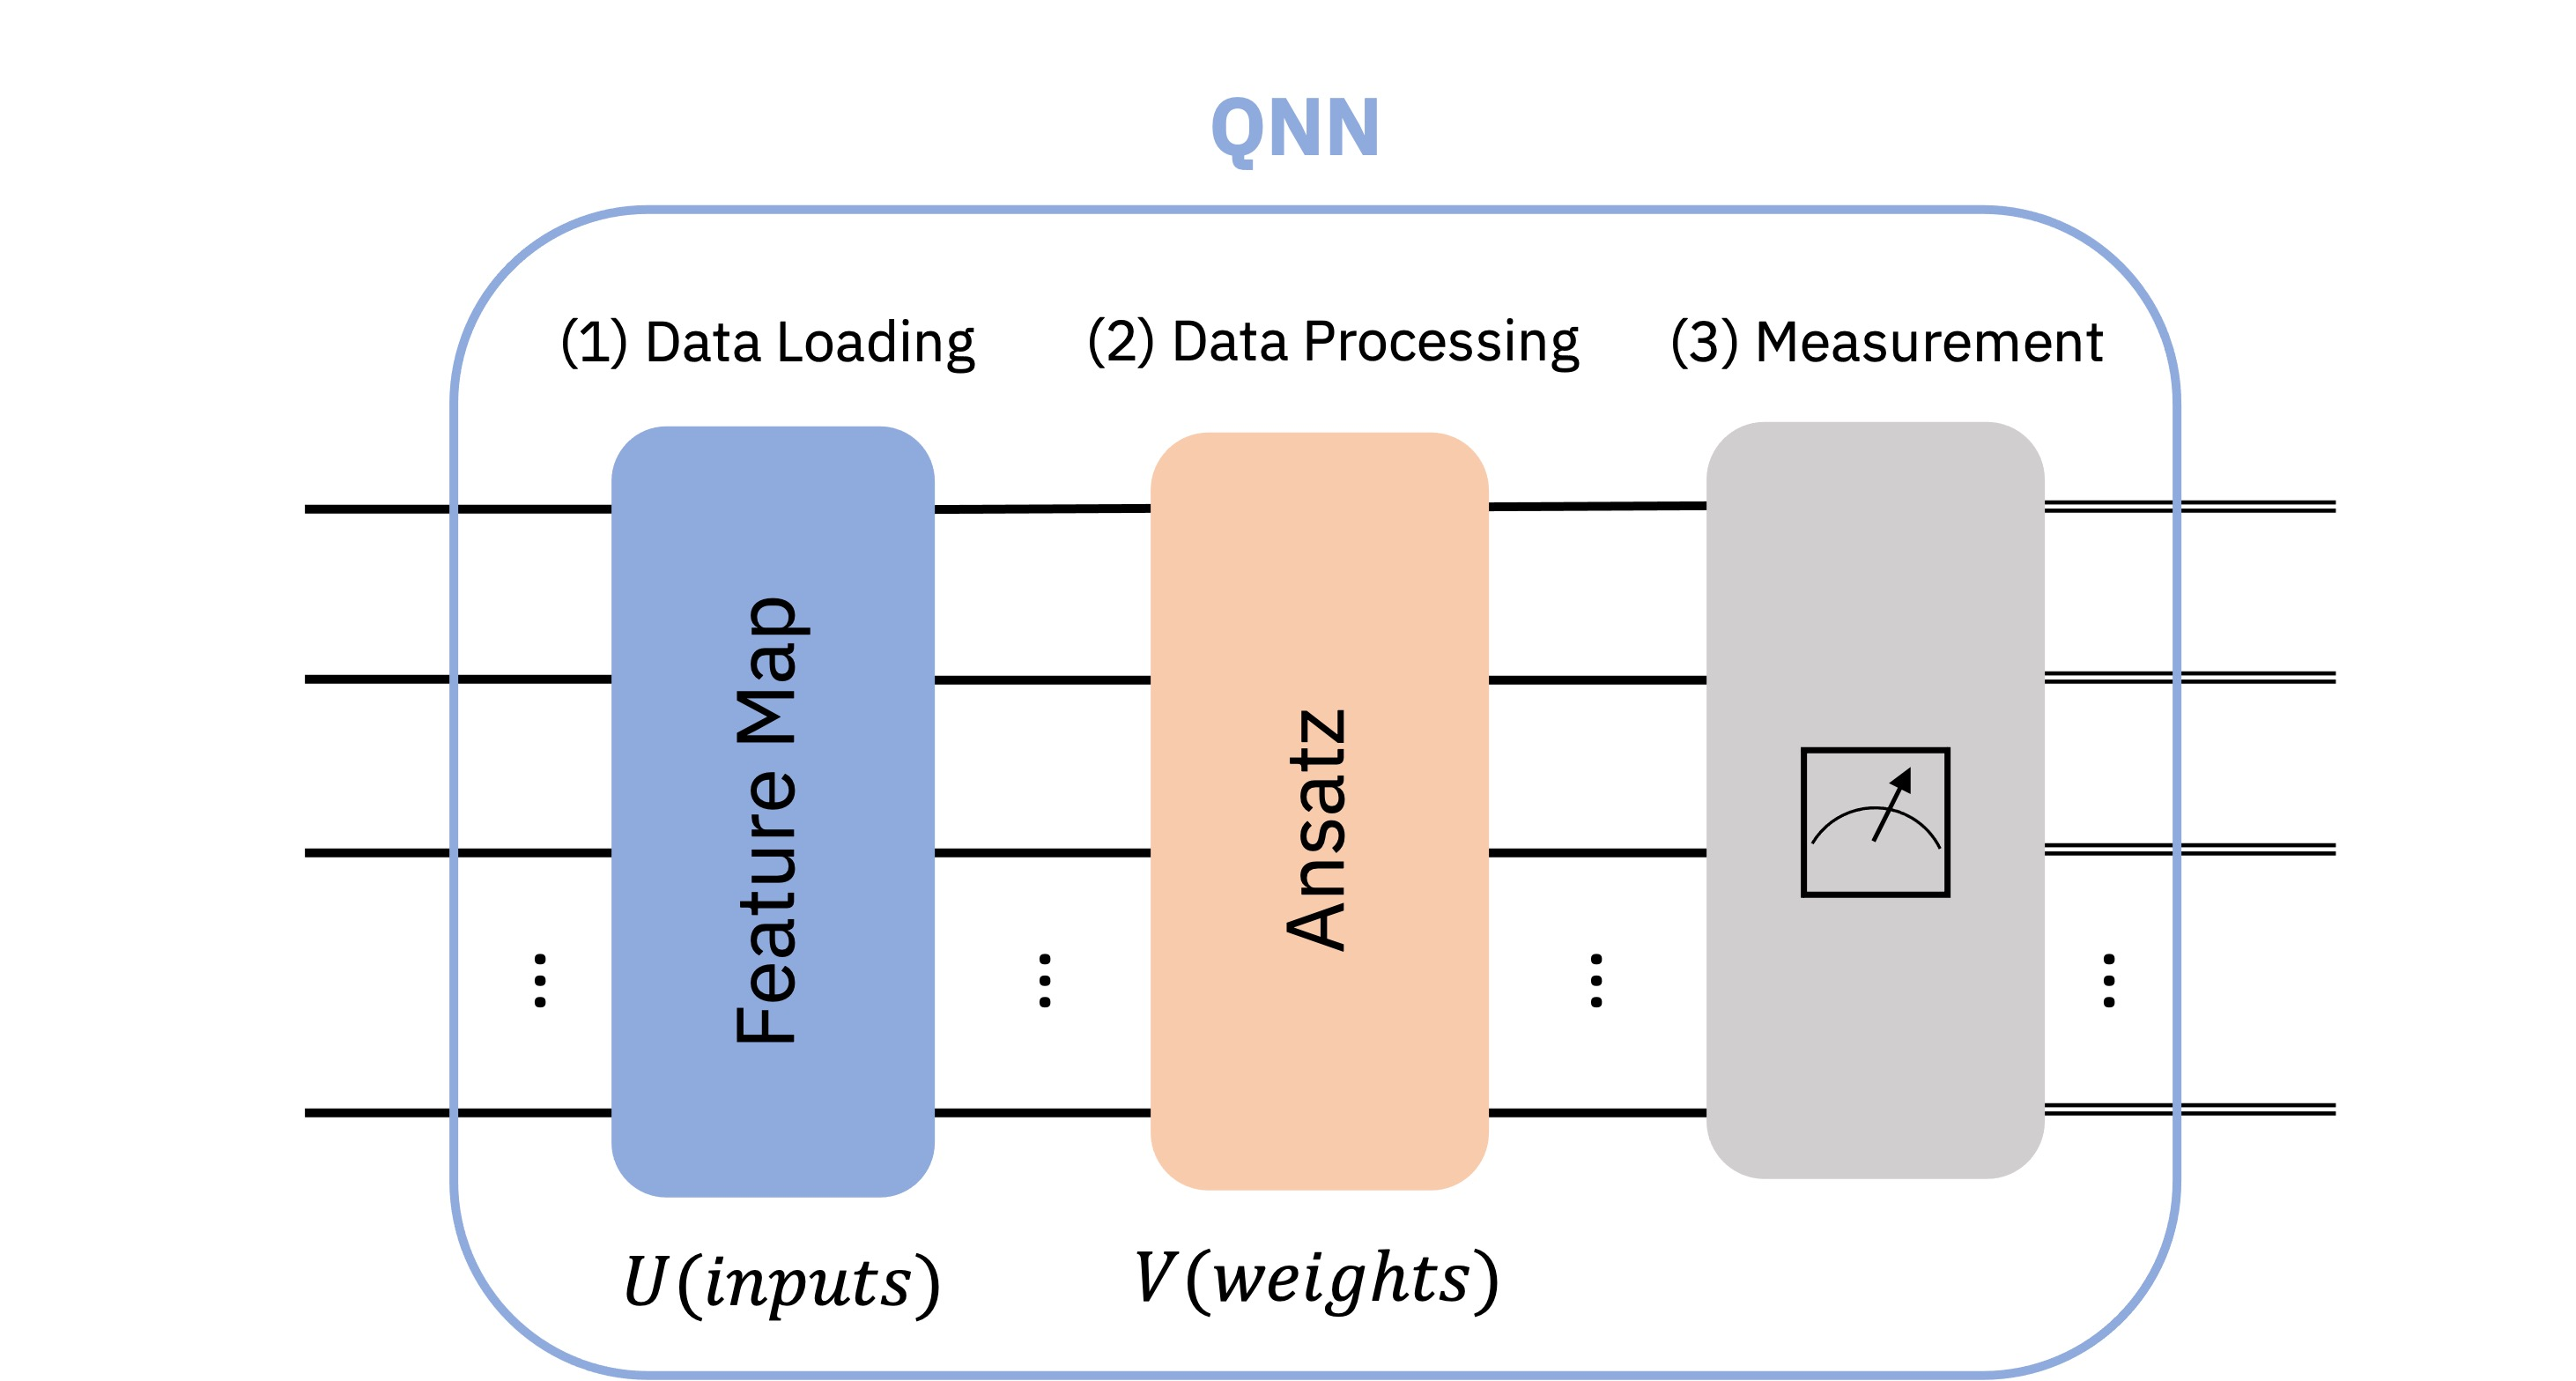


*Figure 1. Generic quantum neural network (QNN) structure.*

As you can see, these two perspectives are complementary, and do not necessarily rely on strict definitions of concepts such as "quantum neuron" or what constitutes a QNN's "layer".

### 1.2. Implementation in `qiskit-machine-learning`

The QNNs in `qiskit-machine-learning` are meant as application-agnostic computational units that can be used for different use cases, and their setup will depend on the application they are needed for. The module contains an interface for the QNNs and two specific implementations:

1. [NeuralNetwork](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html): The interface for neural networks. This is an abstract class all QNNs inherit from.
2. [EstimatorQNN](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html): A network based on the evaluation of quantum mechanical observables.
3. [SamplerQNN](https://qiskit.org/documentation/machine-learning/locale/fr_FR/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html): A network based on the samples resulting from measuring a quantum circuit.


These implementations are based on the [qiskit primitives](https://qiskit.org/documentation/apidoc/primitives.html). The primitives are the entry point to run QNNs on either a simulator or real quantum hardware. Each implementation, `EstimatorQNN` and `SamplerQNN`, takes in an optional instance of its corresponding primitive, which can be any subclass of `BaseEstimator` and `BaseSampler`, respectively.

The `qiskit.primitives` module provides a reference implementation for the `Sampler` and `Estimator` classes to run statevector simulations. By default, if no instance is passed to a QNN class, an instance of the corresponding reference primitive (`Sampler` or `Estimator`) is created automatically by the network.
For more information about primitives please refer to the [primitives documentation](https://qiskit.org/documentation/apidoc/primitives.html).

The `NeuralNetwork` class is the interface for all QNNs available in `qiskit-machine-learning`.
It exposes a forward and a backward pass that take data samples and trainable weights as input.

It's important to note that `NeuralNetwork`s are "stateless". They do not contain any training capabilities (these are pushed to the actual algorithms or applications: [classifiers](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#classifiers), [regressors](https://qiskit.org/documentation/machine-learning/apidocs/qiskit_machine_learning.algorithms.html#regressors), etc), nor do they store the values for trainable weights.

***

Let's now look into specific examples for the two `NeuralNetwork` implementations. But first, let's set the algorithmic seed to ensure that the results don't change between runs.

In [1]:
# Download all libraries before run notebook
!pip install qiskit
!pip install pylatexenc
!pip install qiskit_machine_learning

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.3/241.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.8 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.41.0-py3-none-any.whl size=12846 sha256=ad3c7c096f3e86616e314b4524f0c65d79fee8b8cff6807084

In [2]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## 2. How to Instantiate QNNs

### 2.1. `EstimatorQNN`

The `EstimatorQNN` takes in a parametrized quantum circuit as input, as well as an optional quantum mechanical observable, and outputs expectation value computations for the forward pass. The `EstimatorQNN` also accepts lists of observables to construct more complex QNNs.

Let's see an `EstimatorQNN` in action with a simple example. We start by constructing the parametrized circuit. This quantum circuit has two parameters, one represents a QNN input and the other represents a trainable weight:

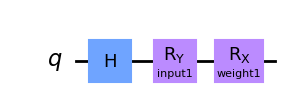

In [3]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc1.draw("mpl")

We can now create an observable to define the expectation value computation. If not set, then the `EstimatorQNN` will automatically create the default observable $Z^{\otimes n}$. Here, $n$ is the number of qubits of the quantum circuit.

In this example, we will change things up and use the $Y^{\otimes n}$ observable:

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable1 = SparsePauliOp.from_list([("Y" * qc1.num_qubits, 1)])

Together with the quantum circuit defined above, and the observable we have created, the `EstimatorQNN` constructor takes in the following keyword arguments:

- `estimator`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

In this example, we previously decided that the first parameter of `params1` should be the input, while the second should be the weight. As we are performing a local statevector simulation, we will not set the `estimator` parameter; the network will create an instance of the reference `Estimator` primitive for us. If we needed to access cloud resources or `Aer` simulators, we would have to define the respective `Estimator` instances and pass them to the `EstimatorQNN`.

In [5]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

estimator_qnn = EstimatorQNN(
    circuit=qc1, observables=observable1, input_params=[params1[0]], weight_params=[params1[1]]
)
estimator_qnn


We'll see how to use the QNN in the following sections, but before that, let's check out the `SamplerQNN` class.

### 2.2. `SamplerQNN`

The `SamplerQNN` is instantiated in a similar way to the `EstimatorQNN`, but because it directly consumes samples from measuring the quantum circuit, it does not require a custom observable.

These output samples are interpreted by default as the probabilities of measuring the integer index corresponding to a bitstring. However, the `SamplerQNN` also allows us to specify an `interpret` function to post-process the samples. This function should be defined so that it takes a measured integer (from a bitstring) and maps it to a new value, i.e. non-negative integer.

**(!)** It's important to note that if a custom `interpret` function is defined, the `output_shape` cannot be inferred by the network, and **needs to be provided explicitly**.

**(!)** It's also important to keep in mind that if no `interpret` function is used, the dimension of the probability vector will scale exponentially with the number of qubits. With a custom `interpret` function, this scaling can change. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, the result will be a probability vector of length 2 independently of the number of qubits.

Let's create a different quantum circuit for the `SamplerQNN`. In this case, we will have two input parameters and four trainable weights that parametrize a  two-local circuit.

input parameters: ['input[0]', 'input[1]']
weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']


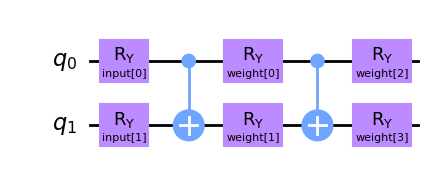

In [6]:
from qiskit.circuit import ParameterVector

inputs2 = ParameterVector("input", 2)
weights2 = ParameterVector("weight", 4)
print(f"input parameters: {[str(item) for item in inputs2.params]}")
print(f"weight parameters: {[str(item) for item in weights2.params]}")

qc2 = QuantumCircuit(2)
qc2.ry(inputs2[0], 0)
qc2.ry(inputs2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[0], 0)
qc2.ry(weights2[1], 1)
qc2.cx(0, 1)
qc2.ry(weights2[2], 0)
qc2.ry(weights2[3], 1)

qc2.draw(output="mpl")

Similarly to the `EstimatorQNN`, we must specify inputs and weights when instantiating the `SamplerQNN`. In this case, the keyword arguments will be:
- `sampler`: optional primitive instance
- `input_params`: list of quantum circuit parameters that should be treated as "network inputs"
- `weight_params`: list of quantum circuit parameters that should be treated as "network weights"

Please note that, once again, we are choosing not to set the `Sampler` instance to the QNN and relying on the default.

In [7]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sampler_qnn = SamplerQNN(circuit=qc2, input_params=inputs2, weight_params=weights2)
sampler_qnn

In addition to the basic arguments shown above, the `SamplerQNN` accepts three more settings: `input_gradients`, `interpret`, and `output_shape`. These will be introduced in sections 4 and 5.

## 3. How to Run a Forward Pass

### 3.1. Set-Up
In a real setting, the inputs would be defined by the dataset, and the weights would be defined by the training algorithm or as part of a pre-trained model. However, for the sake of this tutorial, we will specify random sets of input and weights of the right dimension:

#### 3.1.1. `EstimatorQNN` Example

In [8]:
estimator_qnn_input = algorithm_globals.random.random(estimator_qnn.num_inputs)
estimator_qnn_weights = algorithm_globals.random.random(estimator_qnn.num_weights)

In [9]:
print(f"Number of input features for EstimatorQNN: {estimator_qnn.num_inputs} \nInput: {estimator_qnn_input}")
print(f"Number of trainable weights for EstimatorQNN: {estimator_qnn.num_weights} \nWeights: {estimator_qnn_weights}")

Number of input features for EstimatorQNN: 1 
Input: [0.77395605]
Number of trainable weights for EstimatorQNN: 1 
Weights: [0.43887844]


#### 3.1.2. `SamplerQNN` Example

In [10]:
sampler_qnn_input = algorithm_globals.random.random(sampler_qnn.num_inputs)
sampler_qnn_weights = algorithm_globals.random.random(sampler_qnn.num_weights)

In [11]:
print(f"Number of input features for SamplerQNN: {sampler_qnn.num_inputs} \nInput: {sampler_qnn_input}")
print(f"Number of trainable weights for SamplerQNN: {sampler_qnn.num_weights} \nWeights: {sampler_qnn_weights}")

Number of input features for SamplerQNN: 2 
Input: [0.85859792 0.69736803]
Number of trainable weights for SamplerQNN: 4 
Weights: [0.09417735 0.97562235 0.7611397  0.78606431]


Once we have the inputs and the weights, let's see the results for batched and non-batched passes.

### 3.2. Non-batched Forward Pass

#### 3.2.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the forward pass is `(1, num_qubits * num_observables)` where `1` in our case is the number of samples:

In [12]:
estimator_qnn_forward = estimator_qnn.forward(estimator_qnn_input, estimator_qnn_weights)

print(f"Forward pass result for EstimatorQNN: {estimator_qnn_forward}. \nShape: {estimator_qnn_forward.shape}")

Forward pass result for EstimatorQNN: [[0.2970094]]. 
Shape: (1, 1)


#### 3.2.2. `SamplerQNN` Example

For the `SamplerQNN` (without a custom interpret function), the expected output shape for the forward pass is `(1, 2**num_qubits)`. With a custom interpret function, the output shape will be `(1, output_shape)`, where `1` in our case is the number of samples:

In [13]:
sampler_qnn_forward = sampler_qnn.forward(sampler_qnn_input, sampler_qnn_weights)

print(f"Forward pass result for SamplerQNN: {sampler_qnn_forward}.  \nShape: {sampler_qnn_forward.shape}")

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (1, 4)


### 3.3. Batched Forward Pass

#### 3.3.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the forward pass is `(batch_size, num_qubits * num_observables)`:

In [14]:
estimator_qnn_forward_batched = estimator_qnn.forward(
    [estimator_qnn_input, estimator_qnn_input], estimator_qnn_weights
)

print(f"Forward pass result for EstimatorQNN: {estimator_qnn_forward_batched}.  \nShape: {estimator_qnn_forward_batched.shape}")

Forward pass result for EstimatorQNN: [[0.2970094]
 [0.2970094]].  
Shape: (2, 1)


#### 3.3.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits)`. With a custom interpret function, the output shape will be `(batch_size, output_shape)`.

In [15]:
sampler_qnn_forward_batched = sampler_qnn.forward(
    [sampler_qnn_input, sampler_qnn_input], sampler_qnn_weights
)

print(f"Forward pass result for SamplerQNN: {sampler_qnn_forward_batched}.  \nShape: {sampler_qnn_forward_batched.shape}")

Forward pass result for SamplerQNN: [[0.01826527 0.25735654 0.5267981  0.19758009]
 [0.01826527 0.25735654 0.5267981  0.19758009]].  
Shape: (2, 4)


## 4. How to Run a Backward Pass

Let's take advantage of the inputs and weights defined above to show how the backward pass works. This pass returns a tuple `(input_gradients, weight_gradients)`. By default, the backward pass will only calculate gradients with respect to the weight parameters.

If you want to enable gradients with respect to the input parameters, you should set the following flag during the QNN instantiation:

```python
qnn = ...QNN(..., input_gradients=True)
```

Please remember that input gradients are **required** for the use of `TorchConnector` for PyTorch integration.

### 4.1. Backward Pass without Input Gradients

#### 4.1.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the weight gradients is `(batch_size, num_qubits * num_observables, num_weights)`:

In [16]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad}")
print(f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}")

Input gradients for EstimatorQNN: None.  
Shape: None
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


#### 4.1.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the forward pass is `(batch_size, 2**num_qubits, num_weights)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_weights)`.:

In [17]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad}")
print(f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}")

Input gradients for SamplerQNN: None.  
Shape: None
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


### 4.2. Backward Pass with Input Gradients

Let's enable the `input_gradients` to show what the expected output sizes are for this option.

In [18]:
estimator_qnn.input_gradients = True
sampler_qnn.input_gradients = True

#### 4.2.1. `EstimatorQNN` Example

For the `EstimatorQNN`, the expected output shape for the input gradients is `(batch_size, num_qubits * num_observables, num_inputs)`:

In [19]:
estimator_qnn_input_grad, estimator_qnn_weight_grad = estimator_qnn.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Input gradients for EstimatorQNN: {estimator_qnn_input_grad}.  \nShape: {estimator_qnn_input_grad.shape}")
print(f"Weight gradients for EstimatorQNN: {estimator_qnn_weight_grad}.  \nShape: {estimator_qnn_weight_grad.shape}")

Input gradients for EstimatorQNN: [[[0.3038852]]].  
Shape: (1, 1, 1)
Weight gradients for EstimatorQNN: [[[0.63272767]]].  
Shape: (1, 1, 1)


#### 4.2.2. `SamplerQNN` Example

For the `SamplerQNN` (without custom interpret function), the expected output shape for the input gradients is `(batch_size, 2**num_qubits, num_inputs)`. With a custom interpret function, the output shape will be `(batch_size, output_shape, num_inputs)`.

In [20]:
sampler_qnn_input_grad, sampler_qnn_weight_grad = sampler_qnn.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Input gradients for SamplerQNN: {sampler_qnn_input_grad}.  \nShape: {sampler_qnn_input_grad.shape}")
print(f"Weight gradients for SamplerQNN: {sampler_qnn_weight_grad}.  \nShape: {sampler_qnn_weight_grad.shape}")

Input gradients for SamplerQNN: [[[-0.05844702 -0.10621091]
  [ 0.38798796 -0.19544083]
  [-0.34561132  0.09459601]
  [ 0.01607038  0.20705573]]].  
Shape: (1, 4, 2)
Weight gradients for SamplerQNN: [[[ 0.00606238 -0.1124595  -0.06856156 -0.09809236]
  [ 0.21167414 -0.09069775  0.06856156 -0.22549618]
  [-0.48846674  0.32499215 -0.32262178  0.09809236]
  [ 0.27073021 -0.12183491  0.32262178  0.22549618]]].  
Shape: (1, 4, 4)


## 5. Advanced Functionality

### 5.1. `EstimatorQNN` with Multiple Observables

The `EstimatorQNN` allows to pass lists of observables for more complex QNN architectures. For example (note the change in output shape):

In [21]:
observable2 = SparsePauliOp.from_list([("Z" * qc1.num_qubits, 1)])

estimator_qnn2 = EstimatorQNN(
    circuit=qc1,
    observables=[observable1, observable2],
    input_params=[params1[0]],
    weight_params=[params1[1]],
)

In [22]:
estimator_qnn_forward2 = estimator_qnn2.forward(estimator_qnn_input, estimator_qnn_weights)
estimator_qnn_input_grad2, estimator_qnn_weight_grad2 = estimator_qnn2.backward(
    estimator_qnn_input, estimator_qnn_weights
)

print(f"Forward output for EstimatorQNN1: {estimator_qnn_forward.shape}")
print(f"Forward output for EstimatorQNN2: {estimator_qnn_forward2.shape}")
print(f"Backward output for EstimatorQNN1: {estimator_qnn_weight_grad.shape}")
print(f"Backward output for EstimatorQNN2: {estimator_qnn_weight_grad2.shape}")

Forward output for EstimatorQNN1: (1, 1)
Forward output for EstimatorQNN2: (1, 2)
Backward output for EstimatorQNN1: (1, 1, 1)
Backward output for EstimatorQNN2: (1, 2, 1)


### 5.2. `SamplerQNN` with custom `interpret`

One common `interpret` method for `SamplerQNN` is the `parity` function, which allows it to perform binary classification. As explained in the instantiation section, using interpret functions will modify the output shape of the forward and backward passes. In the case of the parity interpret function, `output_shape` is fixed to `2`. Therefore, the expected forward and weight gradient shapes are `(batch_size, 2)` and `(batch_size, 2, num_weights)`, respectively:

In [23]:
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # parity = 0, 1

sampler_qnn2 = SamplerQNN(
    circuit=qc2,
    input_params=inputs2,
    weight_params=weights2,
    interpret=parity,
    output_shape=output_shape,
)

In [24]:
sampler_qnn_forward2 = sampler_qnn2.forward(sampler_qnn_input, sampler_qnn_weights)
sampler_qnn_input_grad2, sampler_qnn_weight_grad2 = sampler_qnn2.backward(
    sampler_qnn_input, sampler_qnn_weights
)

print(f"Forward output for SamplerQNN1: {sampler_qnn_forward.shape}")
print(f"Forward output for SamplerQNN2: {sampler_qnn_forward2.shape}")
print(f"Backward output for SamplerQNN1: {sampler_qnn_weight_grad.shape}")
print(f"Backward output for SamplerQNN2: {sampler_qnn_weight_grad2.shape}")

Forward output for SamplerQNN1: (1, 4)
Forward output for SamplerQNN2: (1, 2)
Backward output for SamplerQNN1: (1, 4, 4)
Backward output for SamplerQNN2: (1, 2, 4)


## 6. Conclusion

In this tutorial, we introduced the two neural networks classes provided by `qiskit-machine-learning`, namely the `EstimatorQNN` and `SamplerQNN`, which extend the base `NeuralNetwork` class. We provided some theoretical background, the key steps for QNN initialization, basic use in forward and backward passes, and advanced functionality.

We now encourage you to play around with the problem setup and see how different circuit sizes, input, and weight parameter lengths influence the output shapes.

